<a href="https://colab.research.google.com/github/InbalBolshinsky/Deep-Learning-Assigments/blob/main/practice4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

import torchvision.transforms as transforms

In [6]:
# Define the transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize: mean and std for each channel
])

# Load the SVHN training dataset
train_dataset = torchvision.datasets.SVHN(
    root='./data',
    split='train',
    download=True,
    transform=transform
)

# Load the SVHN test dataset
test_dataset = torchvision.datasets.SVHN(
    root='./data',
    split='test',
    download=True,
    transform=transform
)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Using downloaded and verified file: ./data/train_32x32.mat
Using downloaded and verified file: ./data/test_32x32.mat
Number of training samples: 73257
Number of test samples: 26032


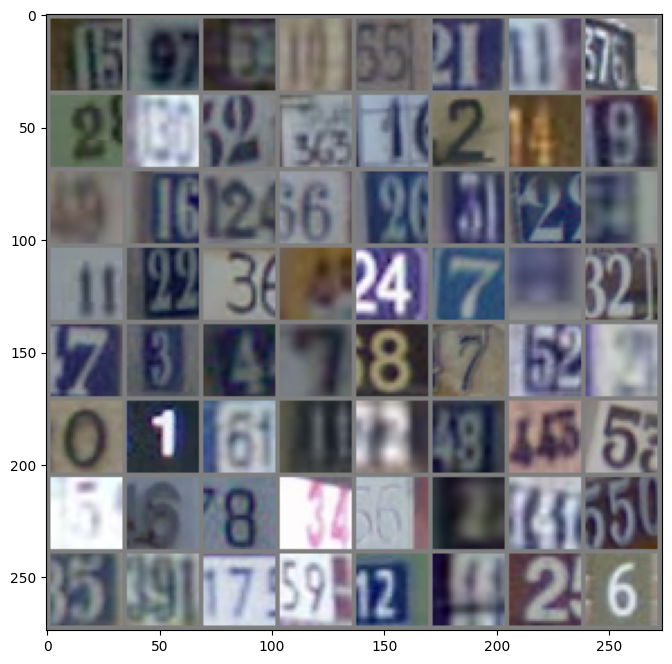

In [7]:
# Helper function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

In [9]:
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
class CNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)  # Added dropout layer
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 64 * 8 * 8)  # Flatten
        x = self.dropout(x)  # Apply dropout
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


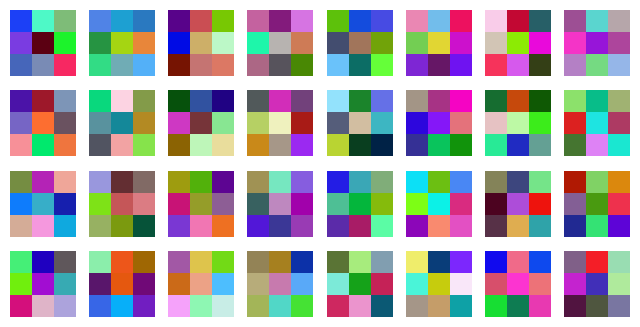

In [10]:
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    filters = filters - filters.min()
    filters = filters / filters.max()
    filter_num = filters.shape[0]
    n_columns = 8
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))
    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(filters[i].permute(1, 2, 0))
        axs[row, col].axis('off')
    plt.show()

# Visualize the filters of the first convolutional layer
model = CNN()
visualize_filters(model.conv1)

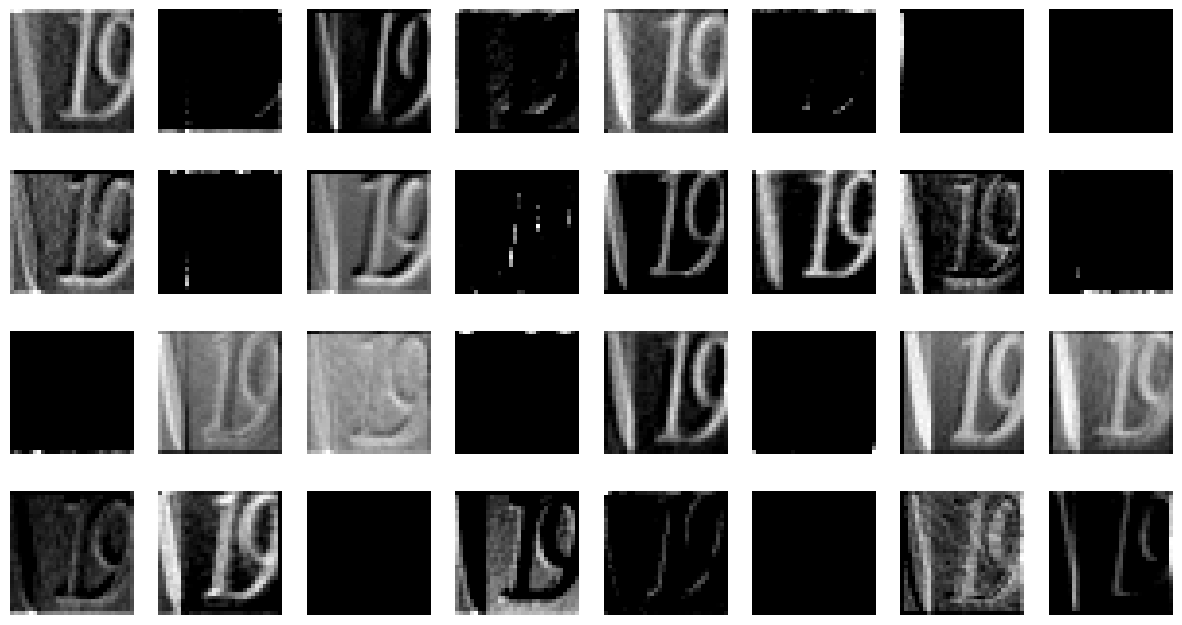

In [11]:
def visualize_feature_maps(image, model):
    x = image.unsqueeze(0)
    x = model.conv1(x)
    x = torch.relu(x)
    feature_maps = x.detach().squeeze(0)
    num_maps = feature_maps.shape[0]
    n_columns = 8
    n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_maps):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
        axs[row, col].axis('off')
    plt.show()

# Visualize feature maps for a single image
sample_image, _ = train_dataset[0]
visualize_feature_maps(sample_image, model)

Using downloaded and verified file: ./data/train_32x32.mat
Epoch 1/12, Train Loss: 1.8898, Val Loss: 1.1578
Epoch 3/12, Train Loss: 1.1443, Val Loss: 0.7401
Epoch 5/12, Train Loss: 0.9648, Val Loss: 0.6357
Epoch 7/12, Train Loss: 0.8861, Val Loss: 0.5644
Epoch 9/12, Train Loss: 0.8412, Val Loss: 0.5784
Epoch 11/12, Train Loss: 0.8127, Val Loss: 0.5010


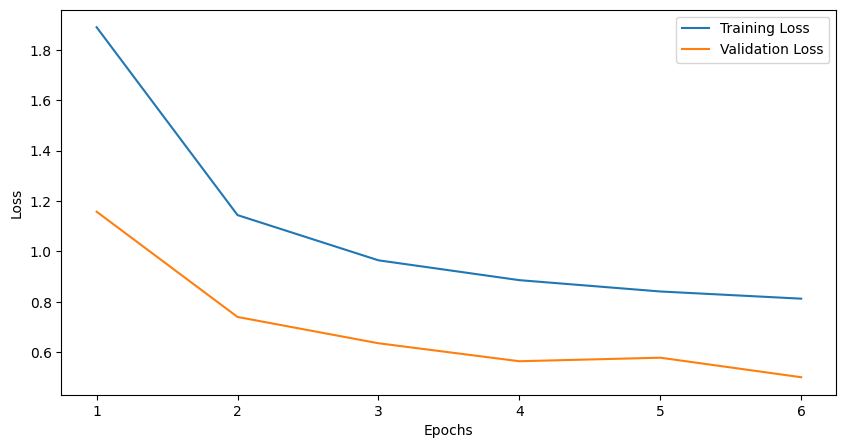

In [21]:
#Updated transformations with data augmentation
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,4),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.SVHN(root='./data', split='train', download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Initialize the model, loss function, and optimizer
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, verbose=True)

# Training loop
num_epochs = 12
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()      # Reset gradients
        outputs = model(inputs)        # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()                # Backpropagation
        optimizer.step()               # Update weights
        running_loss += loss.item()

    # Validation phase
    if epoch%2 == 0:
      train_loss = running_loss/len(train_loader)
      train_losses.append(train_loss)
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in test_loader:
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
      val_loss = val_loss/len(test_loader)
      val_losses.append(val_loss)
      #scheduler.step(val_loss)

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, int(num_epochs/2)+1), train_losses, label='Training Loss')
plt.plot(range(1, int(num_epochs/2)+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []
import torch

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure the model is on the correct device
model.to(device)

model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # Disable gradient calculation for inference
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to the device (e.g., GPU or CPU)
        outputs = model(inputs)  # Perform forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get class predictions
        total += labels.size(0)  # Total number of samples
        correct += (predicted == labels).sum().item()  # Count correct predictions
        all_preds.extend(predicted.cpu().numpy())  # Collect predictions
        all_labels.extend(labels.cpu().numpy())  # Collect true labels

# Calculate accuracy
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")


Test Accuracy: 84.25%


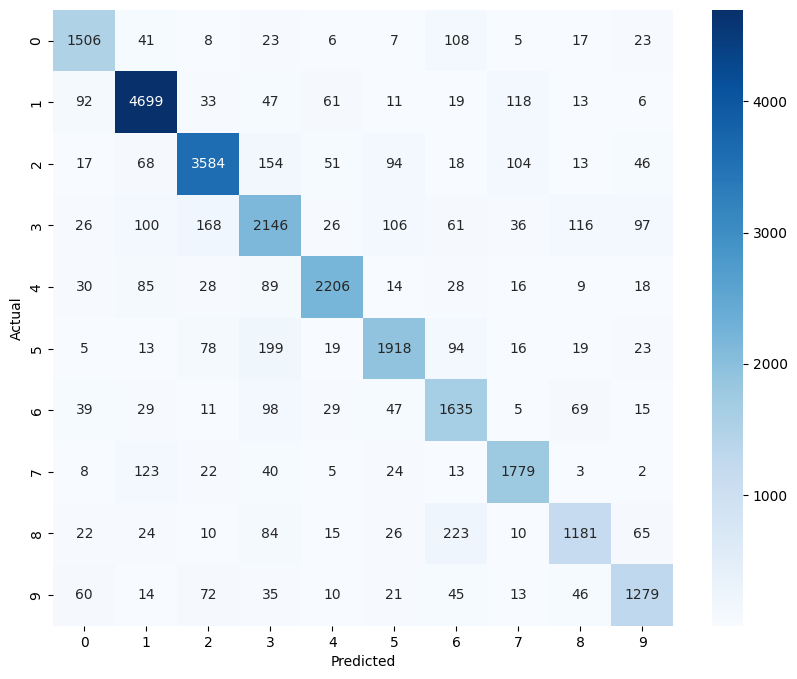

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# SVHN labels are 0-9
classes = list(range(10))  # Create a list of classes from 0 to 9

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

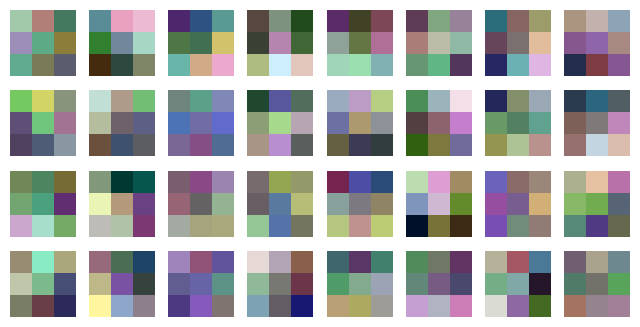

In [27]:
# Visualize the filters of the first convolutional layer after training
visualize_filters(model.conv1)

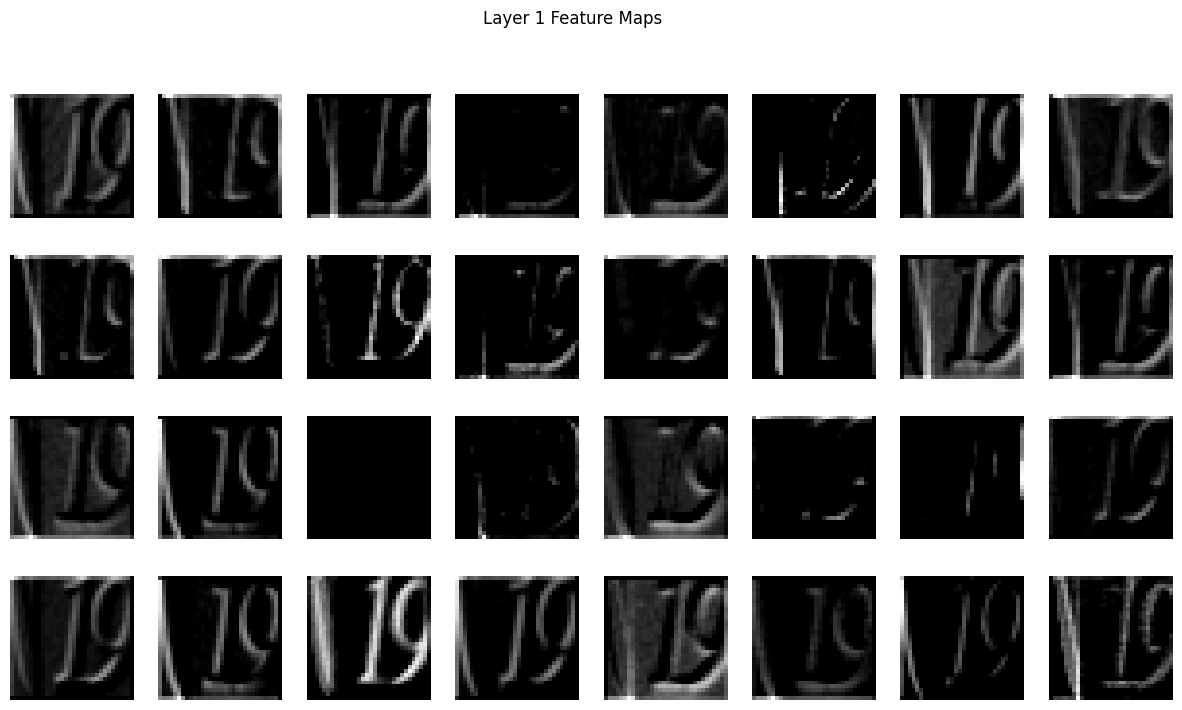

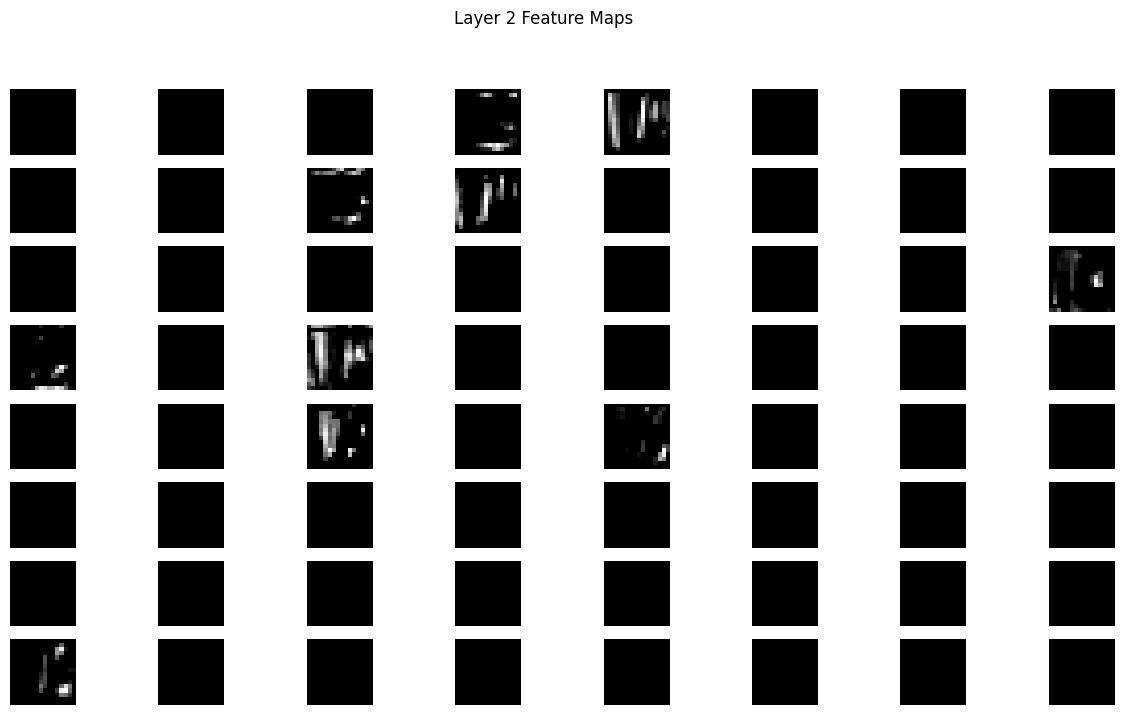

In [28]:
def visualize_intermediate_layers(image, model):
    activations = []
    x = image.unsqueeze(0)
    x = model.conv1(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)
    x = model.conv2(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)

    for idx, activation in enumerate(activations):
        feature_maps = activation.detach().squeeze(0)
        num_maps = feature_maps.shape[0]
        n_columns = 8
        n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
        fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
        fig.suptitle(f'Layer {idx+1} Feature Maps')
        for i in range(min(num_maps, n_columns * n_rows)):
            row = i // n_columns
            col = i % n_columns
            axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
            axs[row, col].axis('off')
        plt.show()

# Visualize feature maps at different layers
visualize_intermediate_layers(sample_image, model)

In [ ]:
# Install skorch if not already installed
!pip install skorch

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

# Define the skorch neural net classifier
net = NeuralNetClassifier(
    CNN,
    max_epochs=10,
    lr=0.01,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    batch_size=64,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

# Prepare the data
X = [data[0].numpy() for data in train_dataset]
y = [data[1] for data in train_dataset]

# Define the parameter grid
params = {
    'lr': [0.01, 0.001],
    'max_epochs': [5, 10],
    'module__dropout': [0.3, 0.5],
    'optimizer': [optim.Adam, optim.SGD],
    'optimizer__weight_decay': [0, 0.0001]
}

# Perform Grid Search
gs = GridSearchCV(net, params, refit=True, cv=3, scoring='accuracy')

import numpy as np
X = np.array(X)
y = np.array(y)

gs.fit(X, y)

# Print the best score and parameters
print('Best score:', gs.best_score_)
print('Best params:', gs.best_params_)

# Use the best model
best_net = gs.best_estimator_

# Test the best model on test data
X_test = [data[0].numpy() for data in test_dataset]
y_test = [data[1] for data in test_dataset]
X_test = np.array(X_test)
y_test = np.array(y_test)

test_acc = best_net.score(X_test, y_test)
print('Test Accuracy:', test_acc)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 4.5 MB/s eta 0:00:00
  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1        2.3292       0.1892        2.2410  76.6691
      2        2.2383       0.1892        2.2389  93.3662
      3        2.2380       0.1892        2.2380  94.6249
      4        2.2379       0.1892        2.2375  93.8843
